In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.metrics import AUC

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv', index_col='id')
print(train.shape)
train.head()

(414, 7)


,gravity,ph,osmo,cond,urea,calc,target
id,,,,,,,
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


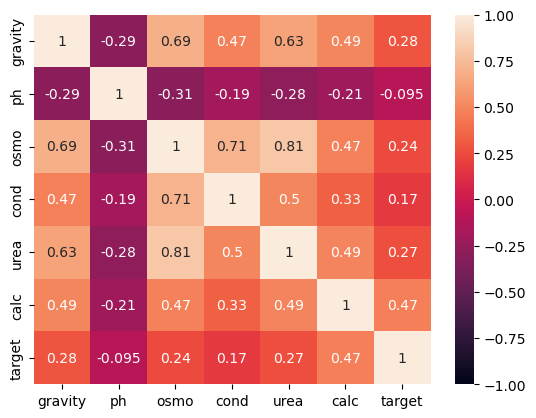

In [3]:
corr_ = train.corr()
sns.heatmap(corr_, xticklabels=corr_.columns, yticklabels=corr_.columns, annot=True, vmin=-1, vmax=1)
plt.show()

In [4]:
X = train.drop('target', axis=1)
y = train.target

In [5]:
X.iloc[:,0]

id
0      1.013
1      1.025
2      1.009
3      1.021
4      1.021
       ...  
409    1.011
410    1.024
411    1.018
412    1.008
413    1.011
Name: gravity, Length: 414, dtype: float64

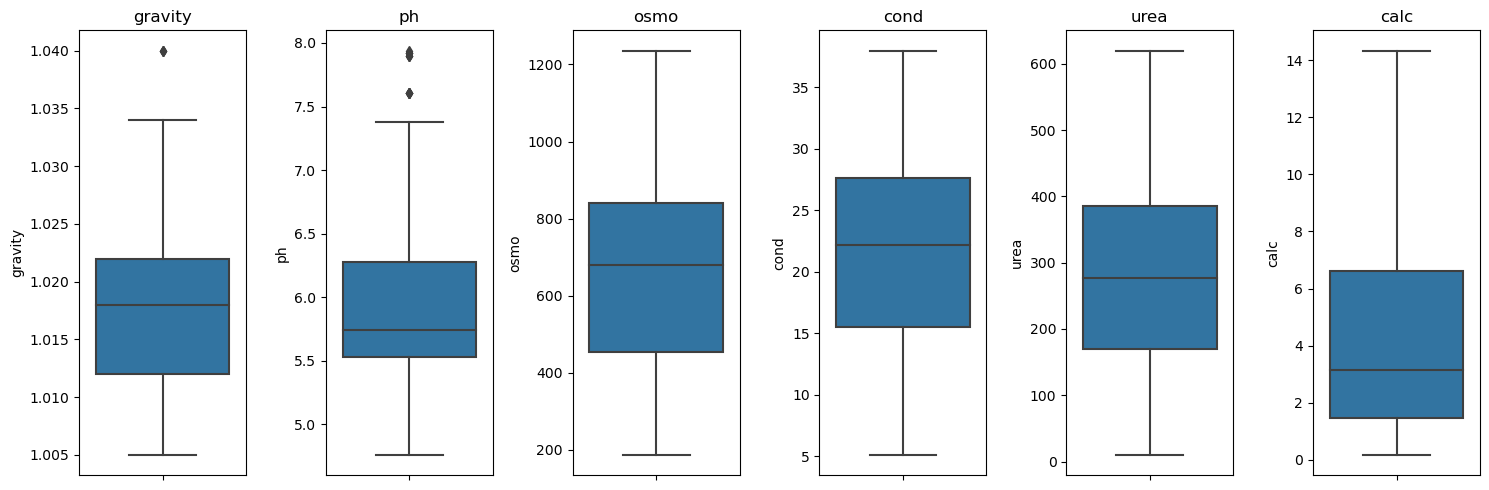

In [6]:
fig, ax = plt.subplots(1,6, figsize=(15,5))

for i in range(6):
    sns.boxplot(ax=ax[i], y=X.iloc[:,i])
    ax[i].set_title(X.columns[i])
    
fig.tight_layout()
fig.show()

In [7]:
qG = np.quantile(X.gravity, 0.99)
qPH = np.quantile(X.ph, 0.96)

X.loc[X.gravity > qG, 'gravity'] = qG
X.loc[X.ph > qPH, 'ph'] = qPH

In [8]:
X.head()

,gravity,ph,osmo,cond,urea,calc
id,,,,,,
0,1.013,6.19,443,14.8,124,1.45
1,1.025,5.40,703,23.6,394,4.18
2,1.009,6.13,371,24.5,159,9.04
3,1.021,4.91,442,20.8,398,6.63
4,1.021,5.53,874,17.8,385,2.21


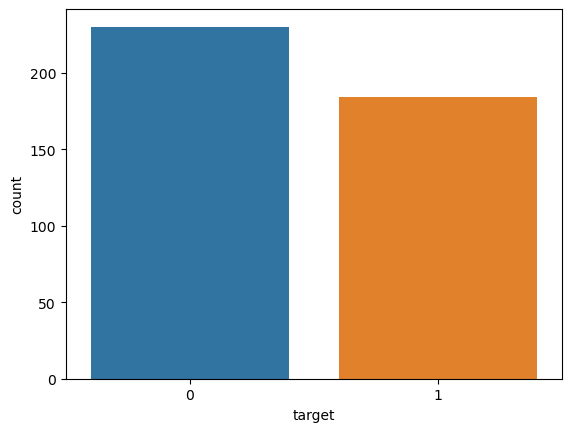

In [9]:
sns.countplot(x=y)
plt.show()

# Neural Network

In [10]:
def get_model(X_train, Y_train):
    model = Sequential(layers=[
        Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='relu'),
#         Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.25),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=[AUC()])
    model.fit(X_train, Y_train, validation_data=(x_val, y_val), epochs=50, verbose=False)
    return model

1. StandardScaler

In [11]:
# X_st = StandardScaler().fit_transform(X)

# x_train, x_val, y_train, y_val = train_test_split(X_st, y, test_size=0.3, random_state=32, stratify=y)

# model_st = get_model(x_train, y_train)
# predict_st = model_st.predict(x_val)
# predict_int_st = (predict_st>0.5).astype('int32')
# print(f'Roc-Auc score: {roc_auc_score(y_val, predict_int_st)}')

2. MinMaxScaler 

In [12]:
# X_mm = MinMaxScaler().fit_transform(X)

# x_train, x_val, y_train, y_val = train_test_split(X_mm, y, test_size=0.3, random_state=32, stratify=y)

# model_mm = get_model(x_train, y_train)
# predict_mm = model_mm.predict(x_val)
# predict_int_mm = (predict_mm>0.5).astype('int32')
# print(f'Roc-Auc score: {roc_auc_score(y_val, predict_int_mm)}')

3. Normalizer

In [13]:
# X_nr = Normalizer().fit_transform(X)

# x_train, x_val, y_train, y_val = train_test_split(X_nr, y, test_size=0.3, random_state=32, stratify=y)

# model_nr = get_model(x_train, y_train)
# predict_nr = model_nr.predict(x_val)
# predict_int_nr = (predict_nr>0.5).astype('int32')
# print(f'Roc-Auc score: {roc_auc_score(y_val, predict_int_nr)}')

# RandomForest

In [14]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=32, stratify=y)
print(f'x_train: {x_train.shape}')
print(f'x_val: {x_val.shape}\n')
st = (StandardScaler(), MinMaxScaler(), Normalizer())

for s in st:
    print(s)
    pipe = make_pipeline(s, RandomForestRegressor())
    pipe.fit(x_train, y_train)
    predict_pipe = pipe.predict(x_val)
    predict_int = (predict_pipe>0.5).astype('int32')
    print(f'Roc-Auc score: {roc_auc_score(y_val, predict_int)}')

x_train: (289, 6)
x_val: (125, 6)

StandardScaler()
Roc-Auc score: 0.6953933747412009
MinMaxScaler()
Roc-Auc score: 0.6881469979296065
Normalizer()
Roc-Auc score: 0.6753364389233955


In [15]:
# params = {'n_estimators':[500, 1000, 1500],
#           'max_depth': [4,5,6],
#           'min_samples_split':[2,3,4]}
# gridSearch = GridSearchCV(RandomForestRegressor(), params)
# gridSearch.fit(x_val, y_val)
# print(f'{gridSearch.best_params_}: {gridSearch.best_score_}')

In [16]:
# model_reg = make_pipeline(MinMaxScaler(), RandomForestRegressor(max_depth=4, min_samples_split=2, n_estimators=1000))
model_reg = RandomForestRegressor(max_depth=4, min_samples_split=2, n_estimators=1000)
model_reg.fit(x_train, y_train)
predict_reg = model_reg.predict(x_val)
predict_int = (predict_reg>0.5).astype('int32')
print(f'Roc-Auc score: {roc_auc_score(y_val, predict_int)}')

Roc-Auc score: 0.697075569358178


In [17]:
# params2 = {'n_estimators':[500, 1000, 1500],
#           'max_depth': [4,5,6],
#           'min_samples_split':[2,3,4],
#           'criterion':['gini','entropy'],
#           'min_samples_leaf':[1,2,4],
#           'random_state': [10, 20, 30]}
# gridSearch2 = GridSearchCV(RandomForestClassifier(), params2)
# gridSearch2.fit(x_val, y_val)
# print(f'{gridSearch2.best_params_}: {gridSearch2.best_score_}')

In [18]:
model_clf = RandomForestClassifier(max_depth=4, min_samples_split=2, n_estimators=500, criterion='gini',
                                  min_samples_leaf=2, random_state=20)
model_clf.fit(X, y)
predict_clf_proba = model_clf.predict_proba(x_val)
predict_clf = model_clf.predict(x_val)
print(f'Roc-Auc score: {roc_auc_score(y_val, predict_clf)}')
print(confusion_matrix(y_val, predict_clf))

Roc-Auc score: 0.7919254658385094
[[60  9]
 [16 40]]


In [19]:
model_clf2 = AdaBoostClassifier(RandomForestClassifier(max_depth=4, min_samples_split=2, n_estimators=500, criterion='gini',
                                  min_samples_leaf=2, random_state=20), n_estimators=150, random_state=32)
model_clf2.fit(X, y)
predict_clf2_proba = model_clf2.predict_proba(x_val)
predict_clf2 = model_clf2.predict(x_val)
print(f'Roc-Auc score: {roc_auc_score(y_val, predict_clf2)}')
print(confusion_matrix(y_val, predict_clf2))

Roc-Auc score: 0.9927536231884059
[[68  1]
 [ 0 56]]


Roc-Auc score: 0.7166149068322982

# Predict test

In [20]:
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv', index_col='id')
print(test.shape)
test.head()

(276, 6)


,gravity,ph,osmo,cond,urea,calc
id,,,,,,
414,1.017,5.24,345,11.5,152,1.16
415,1.020,5.68,874,29.0,385,3.46
416,1.024,5.36,698,19.5,354,13.00
417,1.020,5.33,668,25.3,252,3.46
418,1.011,5.87,567,29.0,457,2.36


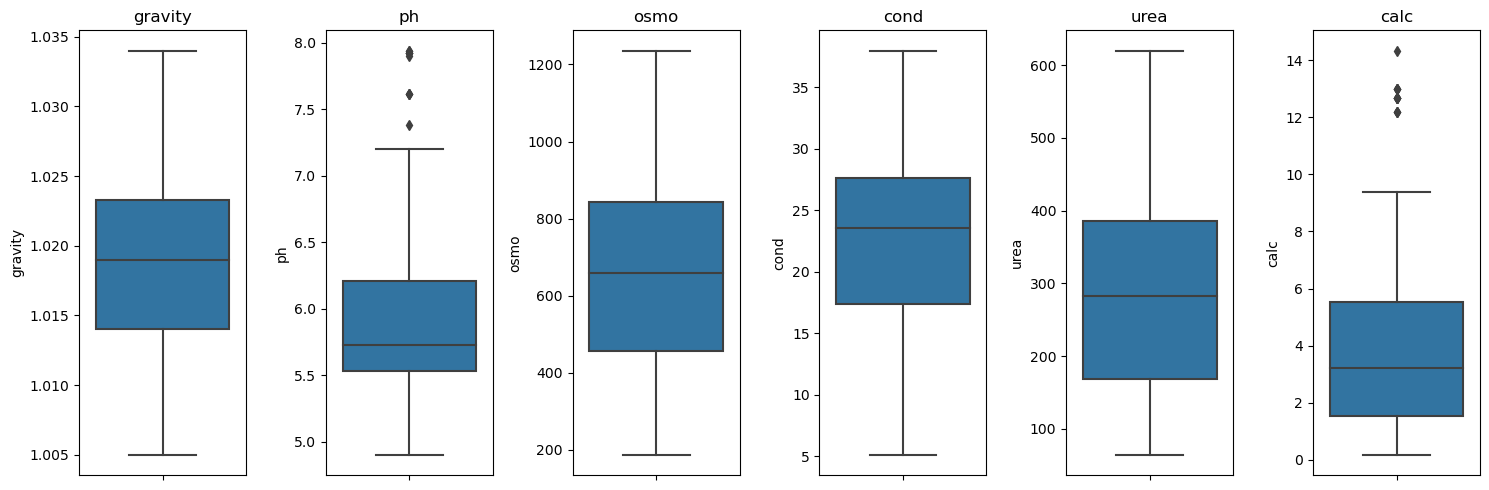

In [21]:
fig, ax = plt.subplots(1,6, figsize=(15,5))

for i in range(6):
    sns.boxplot(ax=ax[i], y=test.iloc[:,i])
    ax[i].set_title(test.columns[i])
    
fig.tight_layout()
fig.show()

In [22]:
qPH = np.quantile(test.ph, 0.96)
qC = np.quantile(test.calc, 0.94)
test.loc[test.ph>qPH, 'ph'] = qPH
test.loc[test.calc>qC, 'calc'] = qC

In [23]:
predict_st_test = model_clf.predict_proba(test)
predict_st_test[:5]

array([[0.76904141, 0.23095859],
       [0.49189768, 0.50810232],
       [0.21122742, 0.78877258],
       [0.530858  , 0.469142  ],
       [0.65439435, 0.34560565]])

In [24]:
mas = []
for i in predict_st_test:
    mas.append(i[-1].round(1))

In [25]:
mas[:5]

[0.2, 0.5, 0.8, 0.5, 0.3]

In [26]:
# predict_st_test

In [27]:
# predict_reg_test = model_reg.predict(test).round(1)
# predict_reg_test[:5]

In [28]:
sample_submission = pd.DataFrame(data={'id':test.index, 'target':mas})
sample_submission.to_csv('sample_submissiom.csv', index=False)